In [2]:
# IMPORTS #
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import label, center_of_mass, gaussian_filter
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D, BatchNormalization, Concatenate
from tensorflow.keras.models import Model

2025-07-01 19:49:49.233928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751424589.246696   12471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751424589.251080   12471 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751424589.261129   12471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751424589.261140   12471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751424589.261141   12471 computation_placer.cc:177] computation placer alr

In [5]:
# CONSTANTS #

DATA_DIR = "/mnt/Research/Data/"
IMAGE_X = 300
IMAGE_Y = 300

GAUSSIAN_X = 48
GAUSSIAN_Y = 48

SCALE_FACTOR = 8

LABEL_X = IMAGE_X // SCALE_FACTOR
LABEL_Y = IMAGE_Y // SCALE_FACTOR

TESTING_GROWTHS = 7
VALIDATION_GROWTHS = 3
IMAGES_PER_GROWTH = 1000

LEFT_CLIP = 100
RIGHT_CLIP = 200
TOP_CLIP = 30
BOTTOM_CLIP = 270

MIN_X_ROLL = 0
MAX_X_ROLL = 300
MIN_Y_ROLL = 0
MAX_Y_ROLL = 300

THRESHOLD = 0.7

# Random Seed
np.random.seed(42)

In [6]:
# Read H5 Data File:
RHEED_data_file = DATA_DIR + 'STO_STO_test6_06292022-standard-compressed.h5'

h5 = h5py.File(RHEED_data_file, 'r')
growths = [g for g in h5.keys()]
np.random.shuffle(growths) # Shuffle Growths
training_spots = growths[:TESTING_GROWTHS]
validation_spots = growths[TESTING_GROWTHS : TESTING_GROWTHS + VALIDATION_GROWTHS]

print("Raw Train Data Set:")
raw_train_data_dict = {}
for growth in training_spots:
    indices = np.random.choice(h5[growth].shape[0], size=IMAGES_PER_GROWTH, replace=False)
    indices.sort()
    raw_train_data_dict[growth] = np.expand_dims(h5[growth][indices], -1).astype(np.float32)
    print(f"[Growth]: {growth:<25}, [Shape]: {raw_train_data_dict[growth].shape}")

print("Raw Validation Data Set:")
raw_validation_data_dict = {}
for growth in validation_spots:
    indices = np.random.choice(h5[growth].shape[0], size=IMAGES_PER_GROWTH, replace=False)
    indices.sort()
    raw_validation_data_dict[growth] = np.expand_dims(h5[growth][indices], -1).astype(np.float32)
    print(f"[Growth]: {growth:<25}, [Shape]: {raw_validation_data_dict[growth].shape}")


Raw Train Data Set:
[Growth]: growth_5                 , [Shape]: (1000, 300, 300, 1)
[Growth]: growth_7                 , [Shape]: (1000, 300, 300, 1)
[Growth]: background_with_heater   , [Shape]: (1000, 300, 300, 1)
[Growth]: growth_8                 , [Shape]: (1000, 300, 300, 1)
[Growth]: growth_12                , [Shape]: (1000, 300, 300, 1)
[Growth]: growth_4                 , [Shape]: (1000, 300, 300, 1)
[Growth]: growth_1                 , [Shape]: (1000, 300, 300, 1)
Raw Validation Data Set:
[Growth]: background_without_heater, [Shape]: (1000, 300, 300, 1)
[Growth]: growth_9                 , [Shape]: (1000, 300, 300, 1)
[Growth]: growth_11                , [Shape]: (1000, 300, 300, 1)


In [7]:
# Aggregate Data
raw_train_data = np.concatenate(list(raw_train_data_dict.values()))
raw_validation_data = np.concatenate(list(raw_validation_data_dict.values()))

print(f"[Train Data Set Shape]: {raw_train_data.shape}")
print(f"[Validation Data Set Shape]: {raw_validation_data.shape}")

[Train Data Set Shape]: (7000, 300, 300, 1)
[Validation Data Set Shape]: (3000, 300, 300, 1)


In [73]:
def img_gen(transform=True):
    
    index = np.random.randint(low=0, high=TESTING_GROWTHS * IMAGES_PER_GROWTH)
    img = raw_train_data[index]
    img_label = orig_label(img)

    # Convert to 8 bit int
    img = (img).astype(np.uint8)

    if transform:
        img, img_label = img_shift(img, img_label)
    
    return (img, img_label)

def orig_label(img):
    img_label = np.zeros(shape=(LABEL_Y, LABEL_X, 1))

    smoothed = gaussian_filter(np.log1p(img[TOP_CLIP:BOTTOM_CLIP , LEFT_CLIP:RIGHT_CLIP]), sigma=2)
    threshold = np.percentile(smoothed, 85)
    binary = smoothed > threshold

    labeled, num_features = label(binary)
    centers = center_of_mass(smoothed, labeled, range(1, num_features + 1))

    for y, x, _ in centers:
        img_label[int(y+TOP_CLIP) // SCALE_FACTOR, int(x+LEFT_CLIP) // SCALE_FACTOR] = 1

    return img_label

def img_shift(img, img_label):
    
    x_roll = np.random.randint(low=MIN_X_ROLL, high=MAX_X_ROLL)
    y_roll = np.random.randint(low=MIN_Y_ROLL, high=MAX_Y_ROLL) 

    img = np.roll(img, y_roll, axis=0)
    img = np.roll(img, x_roll, axis=1)

    new_img_label = np.zeros(shape=(LABEL_Y, LABEL_X, 1))
    for x in range(LABEL_X):
        for y in range(LABEL_Y):
            if img_label[y, x] == 1:
                new_img_label[(y + (y_roll // SCALE_FACTOR)) % LABEL_Y, (x + (x_roll // SCALE_FACTOR)) % LABEL_X] = 1
    
    return (img, new_img_label)



def img_scale():
    pass

def img_visualization_one(img: np.ndarray, img_label: np.ndarray, params: list = None, threshold: int = THRESHOLD) -> None:
    rgb_image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Coords of Gaussians:
    for x in range(LABEL_X):
        for y in range(LABEL_Y):
            if img_label[y, x,] >= threshold:
                
                top_left = (x * SCALE_FACTOR - GAUSSIAN_X // 2, y * SCALE_FACTOR - GAUSSIAN_Y // 2)
                bottom_right = (x * SCALE_FACTOR + GAUSSIAN_X // 2, y * SCALE_FACTOR + GAUSSIAN_Y // 2)
                color = (0, 200, 200)
                thickness = 2
                
                cv2.rectangle(rgb_image, top_left, bottom_right, color, thickness)

    if params != None:
        for param in params:
            print(
            f"[(c_x, c_y)]: ({param[0]:<3}, {param[1]:<3}) "
            f"[(s_x, s_y)]: ({param[2]:<3}, {param[3]:<3}) "
            f"[Theta]: {param[4]:.2f} "
            f"[I]: {param[5]:.2f} "
            )
    
    plt.imshow(rgb_image)

def img_visualization_two(img: np.ndarray, img_label: np.ndarray, params: list = None) -> None:
    
    if params != None:
        for param in params:
            print(
            f"[(c_x, c_y)]: ({param[0]:<3}, {param[1]:<3}) "
            f"[(s_x, s_y)]: ({param[2]:<3}, {param[3]:<3}) "
            f"[Theta]: {param[4]:.2f} "
            f"[I]: {param[5]:.2f} "
            )

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_label, cmap='gray')

def _visualize():
    index = np.random.randint(low=0, high=TESTING_GROWTHS * IMAGES_PER_GROWTH)
    smoothed = gaussian_filter(np.log1p(raw_train_data[index, TOP_CLIP:BOTTOM_CLIP , LEFT_CLIP:RIGHT_CLIP]), sigma=2)

    threshold = np.percentile(smoothed, 80)
    binary = smoothed > threshold

    labeled, num_features = label(binary)
    centers = center_of_mass(smoothed, labeled, range(1, num_features + 1))

    plt.imshow(np.log1p(raw_train_data[index]), cmap='gray')
    plt.colorbar()
    plt.title('Image with Gaussian Centers')
    
    for y, x, _ in centers:
        plt.plot(x+LEFT_CLIP, y+TOP_CLIP, 'rx', markersize=5, markeredgewidth=2)

    plt.show()

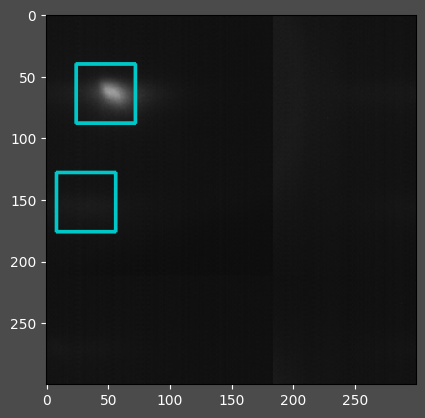

In [38]:
# Test Functions:
img, img_label = img_gen()
img_visualization_one(img, img_label)

In [39]:
# Generate Training Data
SAMPLE_COUNT = 10000
img_arr = []
label_arr = []

def process_image():
    img, img_label = img_gen()
    return img, img_label

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image) for _ in range(SAMPLE_COUNT)]
    for future in tqdm(as_completed(futures), total=SAMPLE_COUNT):
        img, img_label = future.result()
        img_arr.append(np.round(img.astype(np.float32) / (np.max(img.astype(np.float32)) + 1) * 256) / 256) # Normalize values to [0, 1)
        label_arr.append(img_label)

img_arr = np.array(img_arr).astype(np.float32)
label_arr = np.array(label_arr).astype(np.float32)

print(f'[Images Shape]: {img_arr.shape}')
print(f'[Labels Shape]: {label_arr.shape}')

100%|██████████| 10000/10000 [00:51<00:00, 192.91it/s]


[Images Shape]: (10000, 300, 300, 1)
[Labels Shape]: (10000, 37, 37, 1)


In [40]:
# Convert Data to tf DataSet 
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((img_arr, label_arr))
dataset = dataset.shuffle(SAMPLE_COUNT, reshuffle_each_iteration=True)
dataset = dataset.batch(BATCH_SIZE)

I0000 00:00:1751425024.130313   12471 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6035 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-07-01 19:57:04.131433: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3600000000 exceeds 10% of free system memory.
2025-07-01 19:57:05.047299: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3600000000 exceeds 10% of free system memory.


In [41]:
# Model Architecture (INCREASE FILTER SIZE? 16, 32, 64)
input_layer = Input(shape=(IMAGE_X, IMAGE_Y, 1), name='InputLayer')

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='lecun_uniform')(input_layer)
x = BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05)(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='lecun_uniform')(x)
x = BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05)(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='lecun_uniform')(x)
x = BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05)(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=2)(x)

x_prob = Conv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid', kernel_initializer='lecun_uniform')(x)

baby_yolo = Model(inputs=input_layer, outputs=x_prob, name='baby_yolo')

In [42]:
# Tensorflow Functions
bce = tf.keras.losses.BinaryCrossentropy()

# def masked_loss(y_true, y_pred):
#     """
#     Compute loss only at locations where y_true == 1.
    
#     Args:
#         y_true: Ground truth labels, shape (batch_size, ...).
#         y_pred: Predicted probabilities, shape (batch_size, ...).
    
#     Returns:
#         Tensor representing the masked loss.
#     """
#     # Clip predictions to avoid log(0) errors
#     y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    
#     # Create a mask for locations where y_true == 1
#     mask = tf.cast(tf.equal(y_true, 1), tf.float32)
    
#     # Compute binary cross-entropy loss
#     bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    
#     # Apply the mask to focus only on locations where y_true == 1
#     masked_loss = mask * bce
    
#     # Compute the mean loss over the masked locations
#     return tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)

@tf.function
def loss_p(y_true, y_pred):
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)
    

In [43]:
# Training Loop
num_epochs = 20

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=num_epochs,
#     decay_rate=0.9)

lr_schedule = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
baby_yolo.compile(optimizer=adam_optimizer, loss=loss_p, run_eagerly=True)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for batch in tqdm(dataset):
        with tf.GradientTape() as tape:
            prediction = baby_yolo(batch[0])
            loss = loss_p(batch[1], prediction)  # Compute the loss
        grads = tape.gradient(loss, baby_yolo.trainable_variables)
        adam_optimizer.apply_gradients(zip(grads, baby_yolo.trainable_variables))
        running_loss += loss.numpy()
        
    average_loss = running_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

  0%|          | 0/313 [00:00<?, ?it/s]2025-07-01 19:57:11.831908: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3600000000 exceeds 10% of free system memory.
I0000 00:00:1751425032.399884   12471 cuda_dnn.cc:529] Loaded cuDNN version 90300
100%|██████████| 313/313 [00:21<00:00, 14.80it/s]


Epoch [1/20], Loss: 1908.1136474609375


100%|██████████| 313/313 [00:18<00:00, 17.05it/s]


Epoch [2/20], Loss: 432.1640319824219


100%|██████████| 313/313 [00:18<00:00, 17.04it/s]


Epoch [3/20], Loss: 341.4178771972656


100%|██████████| 313/313 [00:18<00:00, 17.23it/s]


Epoch [4/20], Loss: 308.5455627441406


100%|██████████| 313/313 [00:18<00:00, 17.09it/s]


Epoch [5/20], Loss: 297.7147216796875


100%|██████████| 313/313 [00:18<00:00, 17.17it/s]


Epoch [6/20], Loss: 290.5315856933594


100%|██████████| 313/313 [00:18<00:00, 17.15it/s]


Epoch [7/20], Loss: 285.78179931640625


100%|██████████| 313/313 [00:18<00:00, 17.17it/s]


Epoch [8/20], Loss: 281.8971862792969


100%|██████████| 313/313 [00:18<00:00, 17.17it/s]


Epoch [9/20], Loss: 277.2738342285156


100%|██████████| 313/313 [00:18<00:00, 17.14it/s]


Epoch [10/20], Loss: 273.92901611328125


100%|██████████| 313/313 [00:18<00:00, 17.18it/s]


Epoch [11/20], Loss: 270.6050109863281


100%|██████████| 313/313 [00:18<00:00, 16.86it/s]


Epoch [12/20], Loss: 267.0262145996094


100%|██████████| 313/313 [00:18<00:00, 16.49it/s]


Epoch [13/20], Loss: 262.6028137207031


100%|██████████| 313/313 [00:18<00:00, 16.76it/s]


Epoch [14/20], Loss: 259.67987060546875


100%|██████████| 313/313 [00:18<00:00, 16.69it/s]


Epoch [15/20], Loss: 256.0884704589844


100%|██████████| 313/313 [00:18<00:00, 17.03it/s]


Epoch [16/20], Loss: 254.73272705078125


100%|██████████| 313/313 [00:18<00:00, 16.68it/s]


Epoch [17/20], Loss: 252.36903381347656


100%|██████████| 313/313 [00:18<00:00, 16.67it/s]


Epoch [18/20], Loss: 250.30320739746094


100%|██████████| 313/313 [00:18<00:00, 17.19it/s]


Epoch [19/20], Loss: 248.67074584960938


100%|██████████| 313/313 [00:18<00:00, 16.97it/s]

Epoch [20/20], Loss: 246.48390197753906


In [74]:
VAL_COUNT = 100
img_arr_val = []
label_arr_val = []

def process_image():
    img, img_label = img_gen(transform=False)
    return img, img_label

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image) for _ in range(VAL_COUNT)]
    for future in tqdm(as_completed(futures), total=VAL_COUNT):
        img, img_label = future.result()
        img_arr_val.append(np.round(img.astype(np.float32) / (np.max(img.astype(np.float32)) + 1) * 256) / 256) # Normalize values to [0, 1)
        label_arr_val.append(img_label)

img_arr_val = np.array(img_arr).astype(np.float32)
label_arr_val = np.array(label_arr).astype(np.float32)

predictions = baby_yolo(img_arr_val[:50])
print(predictions.shape)

100%|██████████| 100/100 [00:00<00:00, 704.77it/s]


(50, 37, 37, 1)


0.7372379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..200.0].


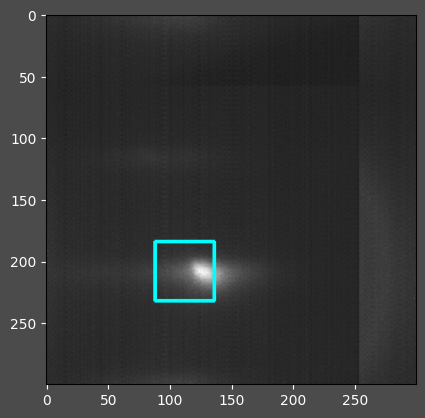

In [79]:
index = np.random.randint(low=0, high=50)
print(np.max(predictions[index]))
img_visualization_one(img_arr_val[index], predictions[index], threshold=0.3)